<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/nebula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nebula Research**

In [83]:
!pip install astropy astroquery reproject lightkurve -q
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy import coordinates
import numpy as np
import matplotlib.pyplot as plt
from astroquery.ipac.irsa import Irsa
from astroquery.simbad import Simbad
from astroquery.ned import Ned
from astroquery.sdss import SDSS
from reproject import reproject_interp
from astropy.visualization import make_lupton_rgb
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import ZScaleInterval
from astropy.visualization import astropy_mpl_style
%matplotlib inline

##### *Define Object and Get Skycoordinates*

In [84]:
# Define object (Nebula name)
#object_name = 'M 27' # Orion Nebula
object_name = 'M 42' # Dumbbell Nebula
#object_name = 'NGC 602' # in Small Magellanic Cloud

In [85]:
# Get skycoordinates of desired object
galaxy = Simbad.query_object(object_name)
ra_hms = galaxy['ra'][0]
dec_dms = galaxy['dec'][0]
print(galaxy)
print("\n")
print("-"*60)
print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

main_id    ra     dec   ... coo_wavelength     coo_bibcode     matched_id
          deg     deg   ...                                              
------- ------- ------- ... -------------- ------------------- ----------
  M  42 83.8201 -5.3876 ...              X 2022A&A...661A..38P      M  42


------------------------------------------------------------
RA (h:m:s): 83.8201
DEC (d:m:s): -5.3876


In [86]:
# Set Coordinates: When Simbad data (RA and DEC columns) are in sexagesimal/hour-angle format:
# coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')

# Set Coordinates: When Simbad data (RA and DEC columns) are in degrees (deg) format:
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit='deg', frame='icrs')

##### *Load FITS infrared images via IRSA*

In [87]:
# How many science picture are therein spitzer_images?
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')
science_images_count = len(spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'])
print("Number of science images:", science_images_count)

Number of science images: 36


In [ ]:
# Query IRSA database (from Spitzer telescope)
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection='spitzer_seip')

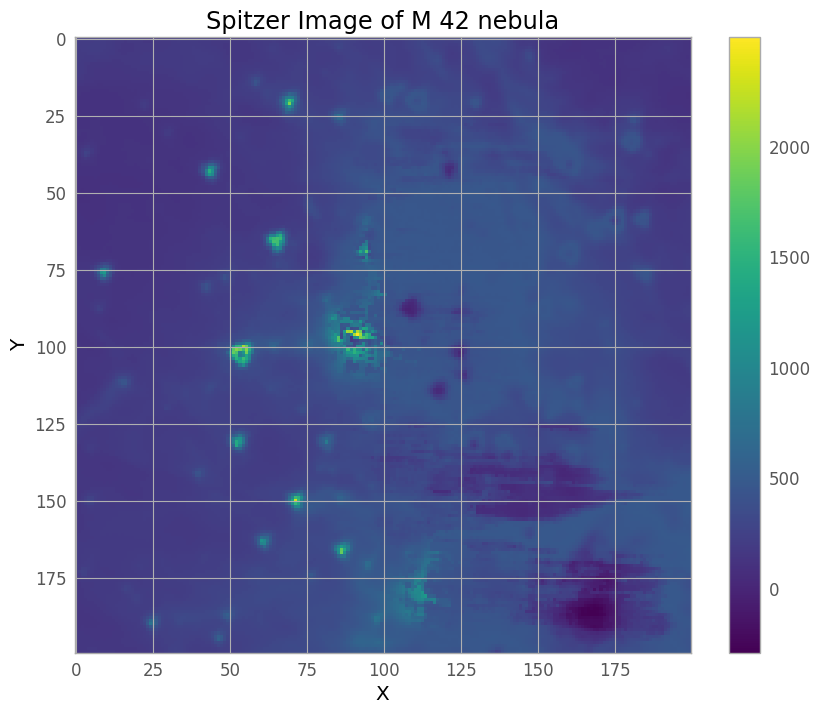

In [ ]:
# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][4]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='viridis')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} nebula')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

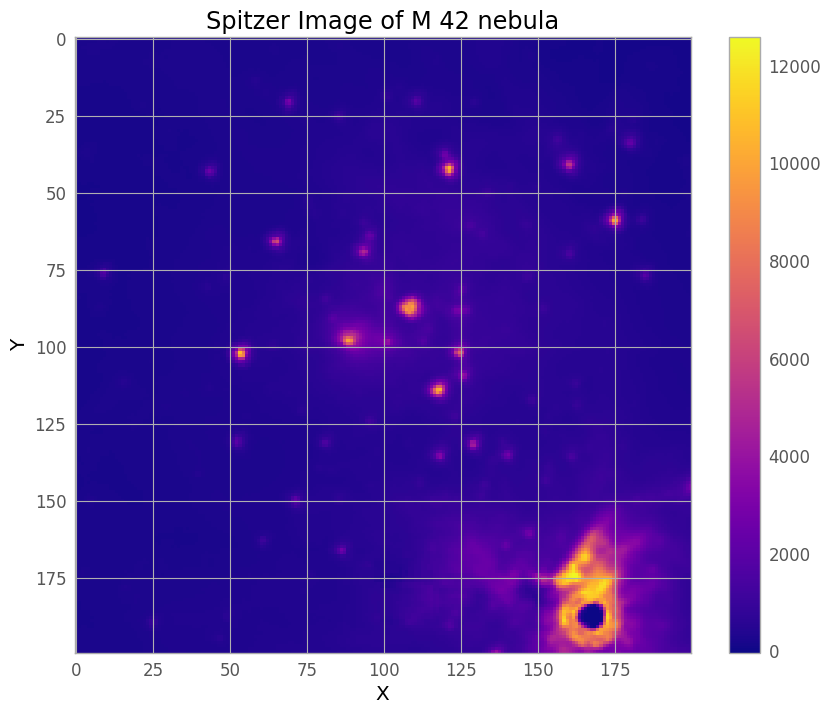

In [ ]:
# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][12]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='plasma')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} nebula')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

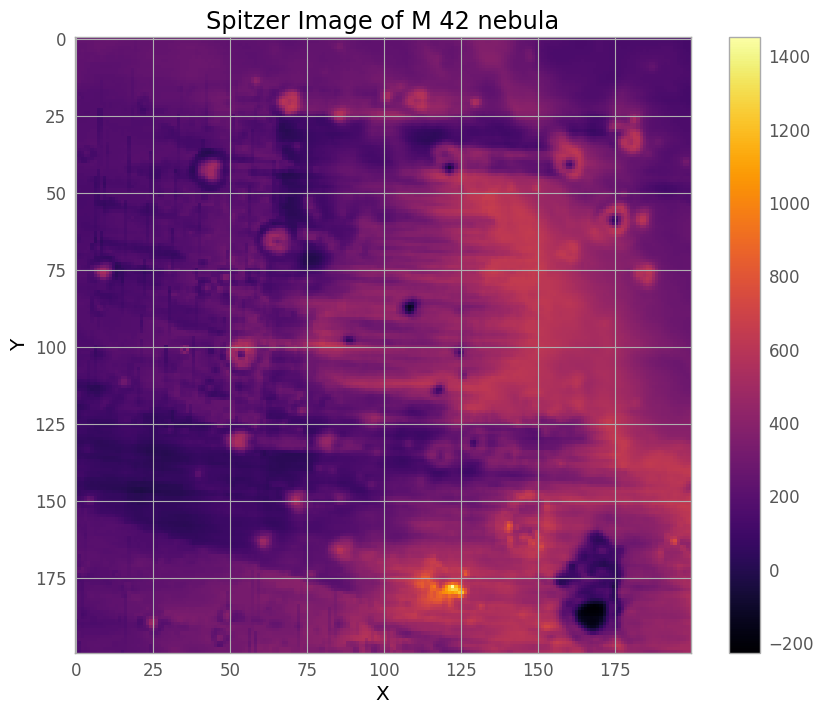

In [ ]:
# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][8]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].data, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8))
plt.imshow(cutout.data, cmap='inferno')
plt.colorbar()
plt.title(f'Spitzer Image of {object_name} nebula')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# Print the file information
hdul = fits.open(science_image['access_url'], use_fsspec=True)
hdul.info()

Filename: <class 'fsspec.implementations.http.HTTPFile'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (1498, 2571)   float32   


In [ ]:
#  Access the primary HDU (Header/Data Unit) to get the data
primary_hdu = hdul[0]
data = primary_hdu.data
print(primary_hdu.header) # Display the header to learn more about the file
print(repr(hdul[0].header))  # Science data HDU header

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel - floating point                NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 1498 / X axis length                                  NAXIS2  =                 2571 / Y axis length                                  ORIGIN  = 'Spitzer Super-Mosaic Pipeline' / Origin of these image data          CREATOR = 'Spitzer Science Center' / Creator of this FITS file                                                                                                            / TIME AND EXPOSURE INFORMATION                                                                                                                       TELESCOP= 'Spitzer '           / Name of Telescope                              INSTRUME= 'IRAC    '           / Name of Instrument                             CHNLNUM =                    3 / Instrum

In [ ]:
# Close the FITS file
hdul.close()

In [ ]:
# Alternative: manually load data from FITS file
#fits_file = 'https://raw.githubusercontent.com/deltorobarba/repo/main/file_apStar-r5-2M05351021-0523215.fits'
#hdulist = fits.open(fits_file)
#hdulist.info()
#header = hdulist[0].header
#print(repr(header))

##### *Load FITS infrared images via SDSS*

In [88]:
# Check SDSS data availability for the region
# we reuse 'coord' from Simbad skycoordinates
# broaden radius to 2 arcmin to ensure the image field is captured
sdss_table = SDSS.query_region(coord, radius=2*u.arcmin)
print(sdss_table)

       ra               dec               objid        run  rerun camcol field
---------------- ----------------- ------------------- ---- ----- ------ -----
83.7907109763756 -5.39081167445895 1237667726440202290 5181   301      3   111
83.8035371583606 -5.38767591084729 1237667726440202265 5181   301      3   111
83.8040116483996 -5.38889713137506 1237667726440202272 5181   301      3   111
83.8037294896017 -5.39228525111305 1237667726440202281 5181   301      3   111
83.8051901532594 -5.39162255759063 1237667726440202262 5181   301      3   111
83.7987732549043 -5.38234490568713 1237667726440202274 5181   301      3   111
83.8020723774267 -5.38854357137709 1237667726440202267 5181   301      3   111
83.8026246830925 -5.38918641007318 1237667726440202270 5181   301      3   111
83.7973237216615 -5.38138899800032 1237667726440202294 5181   301      3   111
83.8241576011097 -5.38498435720738 1237671558084755519 6073   301      4    63
             ...               ...                 .

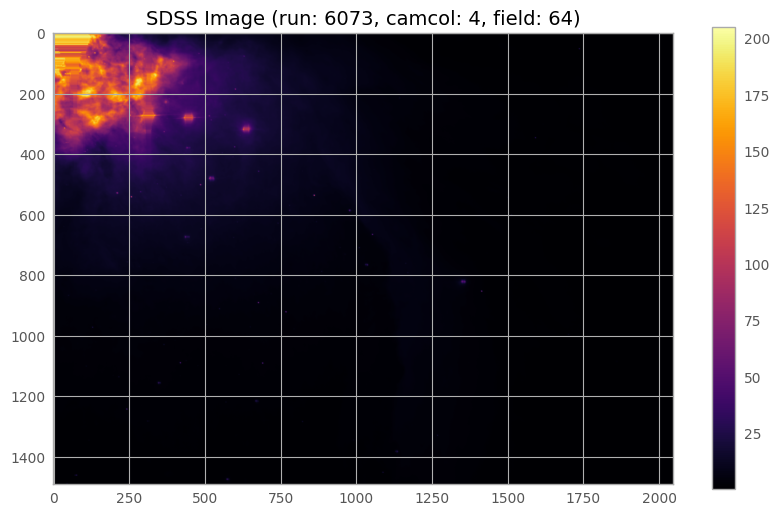

In [99]:
plt.style.use(astropy_mpl_style)

# Define the SDSS parameters from the result table (example)
run = 6073
rerun = 301
camcol = 4
field = 64

#run = sdss_table['run'][0]
#rerun = sdss_table['rerun'][0]
#camcol = sdss_table['camcol'][0]
#field = sdss_table['field'][0]

# Query the image using the specific SDSS parameters
try:
    # Adjust the filter band (e.g., 'r', 'g', 'i', 'z') to see how the object appears in different wavelengths
    images = SDSS.get_images(run=run, rerun=rerun, camcol=camcol, field=field, band='g')

    # Display the first image result
    for image in images:
        plt.figure(figsize=(10, 10)) # Main plot size
        plt.imshow(image[0].data, cmap='inferno') # Display the image data
        cbar = plt.colorbar(shrink=0.6) # Shrink to make colorbar vertically smaller
        cbar.ax.tick_params(labelsize=10) # Font size of colorbar ticks
        plt.title(f'SDSS Image (run: {run}, camcol: {camcol}, field: {field})', fontsize=14)
        plt.tick_params(axis='both', which='major', labelsize=10) # Axis labels and ticks
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

# For more detailed information, overlay contours or perform image analysis with astropy or photutils